# CNN Implementation with PyTorch

Dataset: CIFAR10 (Ref: https://www.cs.toronto.edu/~kriz/cifar.html)
Info: <br>
> Number of Images: 60000,  32 * 32 in resolution
> Number of Classes: 10 (Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck)

**Prerequisites**
> PyTorch Basics: https://youtu.be/OIenNRt2bjg
> Python Basics: https://youtu.be/rfscVS0vtbw

**References:**
1. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
2. https://wandb.ai/authors/ayusht/reports/Implementing-Dropout-Regularization-in-PyTorch--VmlldzoxNTgwOTE
3. https://medium.com/artificialis/dropout-regularization-using-pytorch-in-python-7765337cb158
3. https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py
4. https://pytorch.org/vision/main/datasets.html
5. https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
6. https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html#:~:text=Tensors%20are%20a%20specialized%20data,GPUs%20or%20other%20hardware%20accelerators.

## Load Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the Necessary Libraries

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import models

## Define transforms (Data Augmentation)

In [ ]:
# Define transforms

# For training set
transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# For testing set
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

**Tensors**
> - Tensors are a specialized data structure that are very similar to arrays and matrices. In PyTorch, we use tensors to encode the inputs and outputs of a model, as well as the model’s parameters.
> - Tensors are similar to NumPy’s ndarrays, except that tensors can run on GPUs or other hardware accelerators. In fact, tensors and NumPy arrays can often share the same underlying memory, eliminating the need to copy data.
> - Tensors are also optimized for automatic differentiation.


# Load datasets and define the

Torchvision provides many built-in datasets in the torchvision.datasets module, as well as utility classes for building your own datasets (https://pytorch.org/vision/main/datasets.html).

> PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

In [ ]:
# Load datasets

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:03<00:00, 48191437.52it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# created dataloaders

batch_size = 25  # Define batch size

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

**Try!**
Here we have used only two sets are training and the testing tests. However, for the hyperparameter tuning we need the validation set as well. Therefore, find out a solution to split the test set into two and, redo the dataset loading and dataloader preparation.

In [ ]:
# Define the classes in the dataset

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Display a Sample of Images

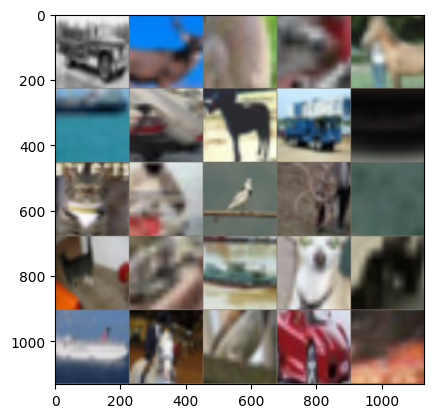

In [ ]:
# Visualize a batch of images

def imshow(img):

    # Define transform to inverse normalize a image
    inv_normalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )

    # Inverse normalize the image
    img = inv_normalize(img)

    # Convert image into a Numpy Array for data manipuation and usage in
    # matplotlib
    npimg = img.numpy()
    # In numpy images defined as no. of channels, height, width format
    # However, matplotlib expects in height, width, channels format
    # So, we need to transform the npimg.
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images, nrow=5))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Define CNN

In [ ]:
# Load pretrained weights for ResNet18

resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet18

truck deer  bird  truck horse ship  truck horse truck car   cat   ship  bird  deer  ship  cat   frog  ship  dog   truck ship  horse bird  car   dog  


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 112MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Freeze the parameters
# So, during the training the the values of these parameters will not be updated

for param in resnet18.parameters():
    param.requires_grad = False

In [ ]:
# Create the CNN model
class CNN(nn.Module):
  def __init__(self, cnn):
    super().__init__()
    self.cnn = cnn
    self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 10)

  # Forward function
  def forward(self, x):
    return self.cnn(x)

In [ ]:
# Initialize a instance of the model

model = CNN(resnet18)

## Define the Device

In [ ]:
# If cuda GPU is available, it will be set as the device otherwise cpu

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Transfer model to the device

model.to(device)

CNN(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [ ]:
# Generate summary

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

## Define the Loss Function and Optimizer

In [ ]:
# Define loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## Train the model

In [ ]:
# Train the defined model

for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0

print("Training Done")

[1,  2000] loss: 1.708
[2,  2000] loss: 1.355
[3,  2000] loss: 1.265
[4,  2000] loss: 1.228
[5,  2000] loss: 1.197
[6,  2000] loss: 1.181
[7,  2000] loss: 1.170
[8,  2000] loss: 1.163
[9,  2000] loss: 1.155
[10,  2000] loss: 1.147
Training Done


## Model Saving and Loading

In [ ]:
# Saving

PATH = '/content/drive/MyDrive/AI/Model Weights/cifar_net.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
# Loading

model = CNN(resnet18) # Optional if you gave done that in one of the previous steps
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
model.to(device)

CNN(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

## Performance with Testset

In [ ]:
# Measure performance of the test set

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest output value is what we choose as prediction
        # torch.max returns two values as (max, max_indices)
        # here we are only interested about the indices not the max value.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct // total} %")

Accuracy of the network on the 10000 test images: 73 %


**Try!** The method we have used here known as freezing, there is another popular method in Transfer Learning that known as fine-tuning. Even though these names use interchangbly, they means to complte different things. Try to redo the task with fine-tuning instead of freezing by yourself :)

**Try!**
In the above cases, we did not utilized any validation set and no hyperparameter tuning has been performed either. So model performance should be able to improve by performing some hyperparameter tuning.

**Try!**
Furthermore, try to measure the training and validation set losses/accuracies within the training loop and plot them in a single plot. In this way, we will be able to identify whether model is overfitting or not. In the above case, neither training or validation losses/accuracies were calculated. Try to record the performance once per certain number of batches.

**Try!**
Try to integrate early stopping into the training loop when the model performance w.r.t the validation set is no longer improving with further training. Try to think of a possible logic and add that into the training loop accordingly.

## Performance for Different Classes

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accurqacy for class {classname:5s} is {accuracy:.1f}%")

Accurqacy for class plane is 76.0%
Accurqacy for class car   is 85.0%
Accurqacy for class bird  is 67.5%
Accurqacy for class cat   is 56.1%
Accurqacy for class deer  is 63.2%
Accurqacy for class dog   is 76.1%
Accurqacy for class frog  is 75.5%
Accurqacy for class horse is 75.9%
Accurqacy for class ship  is 77.1%
Accurqacy for class truck is 82.3%
